In [14]:
from autogluon.tabular import TabularDataset, TabularPredictor
import numpy as np
import math

In [15]:
train_data = TabularDataset(f'Data/phil_socdata_train.csv')
train_data.head()

Loaded data from: Data/phil_socdata_train.csv | Columns = 4 / 4 | Rows = 427326 -> 427326


,SOC,V,I,T
0,100.000031,400.125,-1.50,16.5
1,100.000031,400.125,-1.56,16.5
2,100.000031,400.125,-1.62,16.5
3,100.000031,400.125,-1.68,16.5
4,100.000031,400.125,-1.74,16.5


In [16]:
label = 'SOC'
train_data[label].describe()

count    427326.000000
mean         67.759531
std          24.669208
min           0.000000
25%          48.627468
50%          72.941200
75%          88.627480
max         100.000031
Name: SOC, dtype: float64

In [17]:
#predictor = TabularPredictor(label=label,eval_metric='root_mean_squared_error').fit(train_data, presets='best_quality',time_limit = 30)


import autogluon.core as ag

nn_options = {  # specifies non-default hyperparameter values for neural network models
    'num_epochs': 10,  # number of training epochs (controls training time of NN models)
    'learning_rate': ag.space.Real(1e-4, 1e-2, default=5e-4, log=True),  # learning rate used in training (real-valued hyperparameter searched on log-scale)
    'activation': ag.space.Categorical('relu', 'softrelu', 'tanh'),  # activation function used in NN (categorical hyperparameter, default = first entry)
    #'dropout_prob': ag.space.Real(0.0, 0.5, default=0.1),  # dropout probability (real-valued hyperparameter)
}

gbm_options = {  # specifies non-default hyperparameter values for lightGBM gradient boosted trees
    'num_boost_round': 100,  # number of boosting rounds (controls training time of GBM models)
    #'num_leaves': ag.space.Int(lower=26, upper=66, default=36),  # number of leaves in trees (integer hyperparameter)
}

hyperparameters = {  # hyperparameters of each model type
                   'GBM': gbm_options,
                   'NN_TORCH': nn_options,  # NOTE: comment this line out if you get errors on Mac OSX
                  }  # When these keys are missing from hyperparameters dict, no models of that type are trained

time_limit = 10*60  # train various models for ~10 min
num_trials = 50  # try at most 5 different hyperparameter configurations for each type of model
search_strategy = 'auto'  # to tune hyperparameters using random search routine with a local scheduler

hyperparameter_tune_kwargs = {  # HPO is not performed unless hyperparameter_tune_kwargs is specified
    'num_trials': num_trials,
    'scheduler' : 'local',
    'searcher': search_strategy,
}

predictor = TabularPredictor(label=label).fit(
    train_data, time_limit=time_limit, auto_stack=True, presets='best_quality',
    hyperparameters=hyperparameters, hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,
)



Fitted model: NeuralNetTorch_BAG_L2/cf83bb4b ...
	-2.2519	 = Validation score   (-root_mean_squared_error)
	96.24s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: NeuralNetTorch_BAG_L2/daa50a26 ...
	-2.348	 = Validation score   (-root_mean_squared_error)
	110.59s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: NeuralNetTorch_BAG_L2/995fde52 ...
	-2.2905	 = Validation score   (-root_mean_squared_error)
	109.61s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: NeuralNetTorch_BAG_L2/c2ca822e ...
	-2.9981	 = Validation score   (-root_mean_squared_error)
	107.06s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: NeuralNetTorch_BAG_L2/6512c768 ...
	-2.1883	 = Validation score   (-root_mean_squared_error)
	97.37s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: NeuralNetTorch_BAG_L2/6d241a69 ...
	-2.093	 = Validation score   (-root_mean_squared_error)
	92.83s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted mo

In [18]:
test_data = TabularDataset(f'Data/phil_socdata_test.csv')

y_pred = predictor.predict(test_data.drop(columns=[label]))
y_pred.head()

Loaded data from: Data/phil_socdata_test.csv | Columns = 4 / 4 | Rows = 18307 -> 18307


0    97.245102
1    97.245102
2    97.245102
3    97.245102
4    97.245102
Name: SOC, dtype: float32

In [19]:
predictor.evaluate(test_data, silent=True)

/home/witvoetk/anaconda3/envs/tf/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(


{'root_mean_squared_error': -3.6227905364757076,
 'mean_squared_error': -13.124611271177944,
 'mean_absolute_error': -2.292441113624483,
 'r2': 0.9797025820631768,
 'pearsonr': 0.990536352096155,
 'median_absolute_error': -1.2646408050195248}

In [20]:
predictor.leaderboard(test_data, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,NeuralNetTorch_BAG_L1/e5a0846d,-2.305707,-2.560160,1.066238,0.003333,66.725271,1.066238,0.003333,66.725271,1,True,53
1,LightGBM_BAG_L1/T23,-2.591418,-2.560138,0.026939,0.001924,2.824901,0.026939,0.001924,2.824901,1,True,23
2,NeuralNetTorch_BAG_L1/cd1ba4e9,-2.594437,-3.096529,0.366323,0.002163,134.940079,0.366323,0.002163,134.940079,1,True,51
3,LightGBM_BAG_L1/T22,-2.598647,-2.608159,0.025806,0.002209,2.761176,0.025806,0.002209,2.761176,1,True,22
4,LightGBM_BAG_L1/T18,-2.608812,-2.582440,0.052677,0.001115,2.740740,0.052677,0.001115,2.740740,1,True,18
...,...,...,...,...,...,...,...,...,...,...,...,...
87,LightGBM_BAG_L1/T25,-14.573701,-14.085714,0.045916,0.002053,2.897425,0.045916,0.002053,2.897425,1,True,25
88,LightGBM_BAG_L2/T17,-14.580410,-13.944717,5.265520,0.100175,430.362688,0.070038,0.001159,6.309425,2,True,71
89,NeuralNetTorch_BAG_L2/71f38805,-14.705932,-20.335694,6.666433,0.102211,516.211612,1.470951,0.003195,92.158348,2,True,82
90,LightGBM_BAG_L1/T17,-14.755333,-14.218415,0.053109,0.002376,3.142682,0.053109,0.002376,3.142682,1,True,17


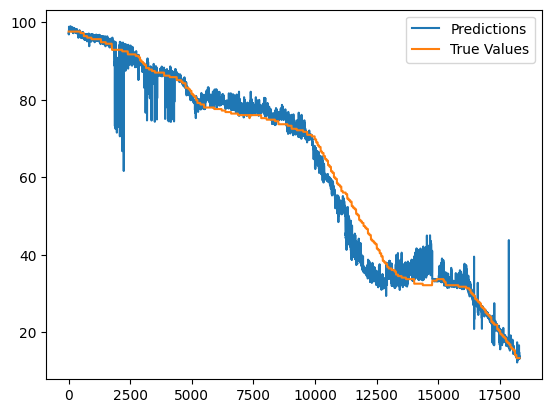

In [21]:
#plots the predicted vs actual values of the top performing model using matplotlib
import matplotlib.pyplot as plt
plt.plot(y_pred, label="Predictions")
plt.plot(test_data[label], label="True Values")
plt.legend()
plt.show()

In [22]:
mse_test = np.mean(((y_pred - test_data[label])**2))
rmse_test = math.sqrt(mse_test)
print("test data rmse", rmse_test)

test data rmse 3.6227905364757076
